In [105]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [7]:
#하이퍼 파라미터

out_channels = 80 #80 filter 출력
kernel_size = 251 #251 frame씩? 싱크함수 길이 L. 센터를 중심으로 대칭이 되기 때문에 홀수 강제.
sample_rate = 16000 # input signal의 sampling rate / sincnet이 주로보는 주파수 영역대가 된다.
in_channels = 1
stride = 1
padding = 0
dilation = 1
bias = False
groups = 1
min_low_hz = 50 # min low hz + low hz 가 f1이 된다.
min_band_hz = 50
low_hz = 30 
high_hz = sample_rate / 2 - (min_low_hz + min_band_hz)  # sinc 함수가 보는 주파수 구간의 upper bound. 7900 정도.

In [8]:


#필터 제작을 위한 mel 변환
def to_mel(hz):
    return 2595*np.log10(1+hz/700)

def to_hz(mel):
    return 700*(10**(mel/2595)-1)


#low cutoff frequency 제작 f1의 초기값.
#mel 에서 추출한 값을 hz로 변환하면, 사람에 적절한 frequency를 얻게 된다.
mel = np.linspace(to_mel(low_hz),to_mel(high_hz),out_channels+1) # 81개로 만들었다가 마지막 값을 버린다. band_hz구하려고 81칸
hz = to_hz(mel)

hz




array([  30.        ,   52.85710786,   76.42989706,  100.74077638,
        125.81285623,  151.66997065,  178.33669994,  205.83839403,
        234.2011966 ,  263.45206991,  293.61882043,  324.73012529,
        356.81555954,  389.90562424,  424.03177549,  459.22645429,
        495.52311744,  532.95626929,  571.56149454,  611.37549211,
        652.43611001,  694.7823813 ,  738.4545612 ,  783.49416539,
        829.94400943,  877.84824949,  927.25242431,  978.20349853,
       1030.74990726, 1084.94160221, 1140.83009909, 1198.46852666,
       1257.91167718, 1319.21605853, 1382.4399479 , 1447.64344722,
       1514.88854026, 1584.23915157, 1655.76120728, 1729.5226977 ,
       1805.59374201, 1884.0466549 , 1964.95601532, 2048.39873735,
       2134.45414336, 2223.20403935, 2314.73279281, 2409.12741283,
       2506.47763286, 2606.87599601, 2710.41794303, 2817.20190298,
       2927.3293869 , 3040.90508422, 3158.0369623 , 3278.83636911,
       3403.41813904, 3531.90070205, 3664.40619629, 3801.06058

In [12]:
#learnable parameter 선언
low_hz_ = torch.nn.Parameter(torch.tensor(hz[:-1]).view(-1,1)) # f1 low cutoff 구현에 사용.
band_hz_ = torch.nn.Parameter(torch.tensor(np.diff(hz)).view(-1,1)) # f2를 구하기위해 차를 구해둔것.

torch.Size([80, 1])

In [22]:
#hamming 윈도우 선언
#컨볼루션 커널 절반에 해당하는 윈도우를 만들고, 대칭할 것.
n_lin = torch.linspace(0,(kernel_size/2)-1,steps=int((kernel_size/2))) # steps : 텐서의 크기. 커널크기 반 만큼 만든다.
# 1~커널크기 반 만큼 등차수열 만든것.
window_ = 0.54 - 0.46*torch.cos(2*torch.pi*n_lin/kernel_size) # 해밍 윈도우 반.
n = (kernel_size -1 )/2.0
n_=2*torch.pi*torch.arange(-n,0).view(1,-1)/sample_rate # 2pi*t구현을 위한것. sinc함수에 들어간다. 음수인 이유는 절반이라서.
# n/f=t: 시간으로. 2pi * t 


# 여기까지 init

In [42]:
# 컷오프 주파수 f1 , f2 만들기
low = (min_low_hz + torch.abs(low_hz_)).float() # f1 구하기. 논문과는 다르다.

#f2 구하기,
high = torch.clamp(input=low+min_band_hz+torch.abs(band_hz_),
                   min = min_low_hz,
                   max = sample_rate/2).float() # 나이퀴스트 정리.


#뒤에 사용하는, 싱크함수를 대칭으로 만들기 위해 정의한 것.
band = (high - low)[:,0]
band

tensor([ 72.8571,  73.5728,  74.3109,  75.0721,  75.8571,  76.6667,  77.5017,
         78.3628,  79.2509,  80.1667,  81.1113,  82.0854,  83.0901,  84.1261,
         85.1947,  86.2967,  87.4332,  88.6052,  89.8140,  91.0606,  92.3463,
         93.6722,  95.0396,  96.4498,  97.9042,  99.4042, 100.9510, 102.5464,
        104.1917, 105.8885, 107.6384, 109.4431, 111.3043, 113.2239, 115.2035,
        117.2451, 119.3506, 121.5221, 123.7615, 126.0710, 128.4529, 130.9094,
        133.4426, 136.0554, 138.7500, 141.5288, 144.3945, 147.3503, 150.3984,
        153.5420, 156.7839, 160.1274, 163.5757, 167.1318, 170.7993, 174.5818,
        178.4827, 182.5056, 186.6543, 190.9331, 195.3462, 199.8970, 204.5903,
        209.4307, 214.4229, 219.5708, 224.8804, 230.3560, 236.0034, 241.8271,
        247.8335, 254.0278, 260.4165, 267.0044, 273.7993, 280.8066, 288.0337,
        295.4868, 303.1729, 311.1001], grad_fn=<SelectBackward0>)

In [60]:
2*band.view(-1,1)

tensor([[145.7142],
        [147.1456],
        [148.6218],
        [150.1442],
        [151.7142],
        [153.3335],
        [155.0034],
        [156.7256],
        [158.5018],
        [160.3335],
        [162.2226],
        [164.1709],
        [166.1801],
        [168.2523],
        [170.3893],
        [172.5934],
        [174.8663],
        [177.2104],
        [179.6281],
        [182.1212],
        [184.6925],
        [187.3444],
        [190.0792],
        [192.8997],
        [195.8085],
        [198.8083],
        [201.9021],
        [205.0928],
        [208.3833],
        [211.7771],
        [215.2769],
        [218.8862],
        [222.6086],
        [226.4478],
        [230.4070],
        [234.4902],
        [238.7012],
        [243.0442],
        [247.5229],
        [252.1421],
        [256.9058],
        [261.8188],
        [266.8853],
        [272.1108],
        [277.5000],
        [283.0576],
        [288.7891],
        [294.7007],
        [300.7969],
        [307.0840],


In [43]:
high.type()

'torch.FloatTensor'

In [88]:
n_.size()

torch.Size([1, 125])

In [95]:
band[:,]

tensor([ 72.8571,  73.5728,  74.3109,  75.0721,  75.8571,  76.6667,  77.5017,
         78.3628,  79.2509,  80.1667,  81.1113,  82.0854,  83.0901,  84.1261,
         85.1947,  86.2967,  87.4332,  88.6052,  89.8140,  91.0606,  92.3463,
         93.6722,  95.0396,  96.4498,  97.9042,  99.4042, 100.9510, 102.5464,
        104.1917, 105.8885, 107.6384, 109.4431, 111.3043, 113.2239, 115.2035,
        117.2451, 119.3506, 121.5221, 123.7615, 126.0710, 128.4529, 130.9094,
        133.4426, 136.0554, 138.7500, 141.5288, 144.3945, 147.3503, 150.3984,
        153.5420, 156.7839, 160.1274, 163.5757, 167.1318, 170.7993, 174.5818,
        178.4827, 182.5056, 186.6543, 190.9331, 195.3462, 199.8970, 204.5903,
        209.4307, 214.4229, 219.5708, 224.8804, 230.3560, 236.0034, 241.8271,
        247.8335, 254.0278, 260.4165, 267.0044, 273.7993, 280.8066, 288.0337,
        295.4868, 303.1729, 311.1001], grad_fn=<SliceBackward0>)

In [97]:
# 싱크함수 만들기

#내부 파라미터 먼저.
f_times_t_low = torch.matmul(low,n_) # [80필터,커널 사이즈 반]
f_times_t_high = torch.matmul(high,n_)

#싱크함수 계산 * 해밍 윈도우
band_pass_left = ((2*torch.sin(f_times_t_high)-2*torch.sin(f_times_t_low))/(n_)) * window_

band_pass_center = 2*band.view(-1,1)
band_pass_right = torch.flip(band_pass_left,dims=[1])

band_pass = torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)
band_pass = band_pass / (2*band[:,None])
#최종 밴드 필터
filters = (band_pass).view(out_channels,1,kernel_size) # 중간에 1인 이유는 1d라서.


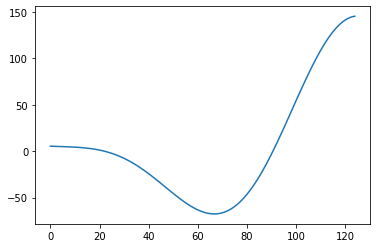

In [58]:
plt.plot(band_pass_left[0].detach().numpy())

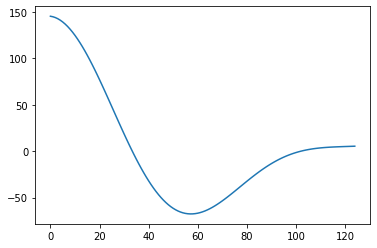

In [83]:
plt.plot(band_pass_right[0].detach().numpy())

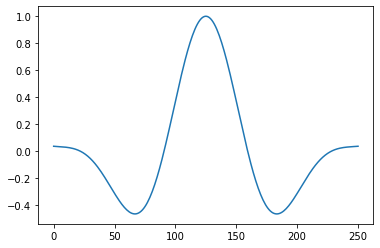

In [104]:
plt.plot(filters[0,:].detach().numpy()[0])